<a href="https://colab.research.google.com/github/otopiachka/markdown-doc/blob/master/Seminar_extra_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Бонусный семинар

**Детекция овощей**

[Кишкун Анастасия](https://kichkun.github.io/)

Skoltech

## Виртуальная поездка "на картошку"

Реальная задача: есть теплица, в которой выращивают огурцы, помидоры, клубнику. Среди плодов и растений, периодически появляются сорняки. 
Задача - научиться выделять плоды, определяя их координаты, с целью автоматического сбора урожая манипулятором, а также научиться выделять сорняки, с целью автоматизированного удаления вредной растительности манипулятором. 

Для решения данной задачи, мы рассмотрим одну из популярных нейронных сетей YOLO, а именно ее "легковесную" версию YOLOV3_TINY предобученную на популярном датасете COCO






### Наш план: 
1. Подготовим датасет: YOLO имеет свой стандартизированный формат данных, который мы рассмотрим, а также рассмотрим удобный инструмент для подготовки и аннотирования изображений в этом формате. Для этого мы воспользуемся инструментом для работы с данными из OpenImages

2. Запустим предобученную сетку, научимся грузить веса и понаблюдаем за магией
3. Дообучение: когда все данные подготовлены,  остается настроить сеть при помощи конфигуратора и запустить обучение
4. *Агументация: для того, чтобы сделать датасет сбалансированным, мы аугментируем(расширим) тренировочную выборку 
5. Тестирование: в завершении, остается наблюдать за быстрой работой сети, а также оценить результат

В данном блоке, мы рассмотрим подход к анализу изображений, основанный на детекции объектов. Особенностью данного подхода является работа с "bounding box" - прямоугольными областями вокруг искомых объектов.




#### COCO DATASET
Крупномасштабный датасет для обнаружения и сегментации объектов. 
- Подходит для сегментации
- 330 тысяч изображений, >200 тысяч размечены
- 1.5 миллиона объектов
- 80 категорий объектов
![image.png](http://cocodataset.org/images/coco-examples.jpg)




#### Open Images

- 15,851,536 "боксов" для детекции на 600 категорий

- 2,785,498 полигонов для сегментации на  350 категорий

Рассмотрим разницу между классификацией, детекцией и сегментацией
![alt text](https://miro.medium.com/max/5856/1*Hz6t-tokG1niaUfmcysusw.jpeg)

Датасет имеет связи по подкатегориям: так, например, категория "Овощи" делится на "Огурцы", "Помидоры" и пр. овощи. 
Из данного датасета мы научимся извлекать необходимые нам объекты




### Подготовка датасета
Получаем репозиторий для OID - с помощью которого мы можем максимально эффективно использовать набор данных Open Images c наменьшими усилиями. Устанавливаем необходимые зависимости

In [1]:
!git clone https://github.com/EscVM/OIDv4_ToolKit.git
!pip install -r ./OIDv4_ToolKit/requirements.txt

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422
Receiving objects: 100% (422/422), 34.08 MiB | 44.74 MiB/s, done.
Resolving deltas: 100% (146/146), done.
     |████████████████████████████████| 1.4MB 17.1MB/s 
     |████████████████████████████████| 7.0MB 40.4MB/s 
     |████████████████████████████████| 552kB 52.6MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for awscli: filename=awscli-1.18.189-py2.py3-none-any.whl size=3441108 sha256=4f3fc34ce9acbf42ff3f927594e8e6e85dda5b26a8921b92cd788fa28d06e617
  Stored in directory: /root/.cache/pip/wheels/dc/ec/a1/59613412e2d3d0aea90754896dbb97b4744f1b17e87166e0e3
Successfully built awscli
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: botocore 1.19.29 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incom

Скачиваем по 10 картинок каждого из 4 классов для обучения (для обучения нужно от 1000, обратите внимание на параметр "limit")

In [3]:
!python ./OIDv4_ToolKit/main.py downloader --classes Tomato Cucumber Strawberry Houseplant --type_csv train --limit 10 --multiclasses 1 -y


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Tomato', 'Cucumber', 'Strawberry', 'Houseplant'] together.

Tomato
    [INFO] | Downloading train images.
    [INFO] | [INFO] Found 1283 online images for train.
    [INFO] | Limiting to 10 imag

Генерируем аннотации. Аннотация - разметка фотографий в формате YOLO, содержащая информацию об объектах на изображении (класс, размер и положение объектов)


In [4]:
import pandas as pd
import os

f=pd.read_csv("./OID/csv_folder/train-annotations-bbox.csv")

#For multiple classes use the below, adding as many new LabelNames as needed
#this one is tomato[0] cucumber[1] strawberry[2] plant[3] in that order
numClasses = ['/m/07j87','/m/015x4r','/m/07fbm7','/m/03fp41']
u = f.loc[f['LabelName'].isin(numClasses)]
keep_col = ['LabelName','ImageID','XMin','XMax','YMin','YMax']

new_f = u[keep_col]

new_f['ClassNumber'] = new_f['LabelName']

# adding a new column for Classnumber and setting the values based on LabelName
# so, for this, it's tomato[0] cucumber[1] strawberry[2] plant[3] in that order
new_f.loc[new_f['LabelName'] == '/m/07j87', 'ClassNumber'] = 0
new_f.loc[new_f['LabelName'] == '/m/015x4r', 'ClassNumber'] = 1
new_f.loc[new_f['LabelName'] == '/m/07fbm7', 'ClassNumber'] = 2
new_f.loc[new_f['LabelName'] == '/m/03fp41', 'ClassNumber'] = 3


new_f['width'] = new_f['XMax'] - new_f['XMin']
new_f['height'] = new_f['YMax'] - new_f['YMin']
new_f['x'] = (new_f['XMax'] + new_f['XMin'])/2
new_f['y'] = (new_f['YMax'] + new_f['YMin'])/2
keep_col = ['ClassNumber','ImageID','x','y','width','height']
new_f_2 = new_f[keep_col]

print (new_f_2)

for root, dirs, files in os.walk("./OID/Dataset/train/Tomato_Cucumber_Strawberry_Houseplant/"):  
	for filename in files:

		if filename.endswith(".jpg"):
			fn = filename[:-4]
			nf = new_f_2.loc[new_f_2['ImageID'] == fn]
			keep_col = ['ClassNumber','x','y','width','height']
			new_nf = nf[keep_col]
			print(new_nf)
			imgpath = "./OID/Dataset/train/Tomato_Cucumber_Strawberry_Houseplant/" + fn + ".txt"
			print(imgpath)
			new_nf.to_csv(imgpath, index=False, header=False, sep=' ')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

         ClassNumber           ImageID         x         y     width    height
4616               2  00030b70a3abfcea  0.177187  0.627479  0.143125  0.189802
4617               2  00030b70a3abfcea  0.297812  0.332861  0.150625  0.163362
8027               2  0005817f5c4ef853  0.195000  0.714822  0.383750  0.566604
8352               3  0005bda112291d3b  0.622138  0.635531  0.347329  0.531136
8735               0  0006124f7e35107e  0.427553  0.298251  0.731591  0.525219
...              ...               ...       ...       ...       ...       ...
14609259           3  fff9d0c14a4e5b06  0.920712  0.271429  0.155340  0.120000
14609506           3  fffb6efdc2fea5d9  0.486250  0.652778  0.203750  0.623333
14609507           3  fffb6efdc2fea5d9  0.610000  0.835000  0.107500  0.136666
14609508           3  fffb6efdc2fea5d9  0.850625  0.535556  0.038750  0.066667
14609584           3  fffbe5b9c8a94382  0.421667  0.562500  0.820000  0.810000

[38226 rows x 6 columns]
         ClassNumber      

Создаем общий файл со списком файлов обучающей выборки - согласно требованиям формата


In [5]:
import glob
train_list = glob.glob("./OID/Dataset/train/Tomato_Cucumber_Strawberry_Houseplant/*.jpg")

with open('./OID/train.txt', 'w') as f:
    for item in train_list:
        f.write("%s\n" % item)

Скачиваем по 10 картинок каждого из 4 классов для валидации - также обращаем внимание на лимит

In [7]:
!python ./OIDv4_ToolKit/main.py downloader --classes Tomato Cucumber Strawberry Houseplant --type_csv validation --limit 10 --multiclasses 1 -y


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Tomato', 'Cucumber', 'Strawberry', 'Houseplant'] together.

Tomato
    [INFO] | Downloading validation images.
    [INFO] | [INFO] Found 56 online images for validation.
    [INFO] | Limiting to

Генерируем аннотации для валидационной части 

In [8]:
f=pd.read_csv("./OID/csv_folder/validation-annotations-bbox.csv")

#For multiple classes use the below, adding as many new LabelNames as needed
#this one is tomato[0] cucumber[1] strawberry[2] plant[3] in that order
numClasses = ['/m/07j87','/m/015x4r','/m/07fbm7','/m/03fp41']
u = f.loc[f['LabelName'].isin(numClasses)]
keep_col = ['LabelName','ImageID','XMin','XMax','YMin','YMax']

new_f = u[keep_col]

new_f['ClassNumber'] = new_f['LabelName']

# adding a new column for Classnumber and setting the values based on LabelName
# so, for this, it's tomato[0] cucumber[1] strawberry[2] plant[3] in that order
new_f.loc[new_f['LabelName'] == '/m/07j87', 'ClassNumber'] = 0
new_f.loc[new_f['LabelName'] == '/m/015x4r', 'ClassNumber'] = 1
new_f.loc[new_f['LabelName'] == '/m/07fbm7', 'ClassNumber'] = 2
new_f.loc[new_f['LabelName'] == '/m/03fp41', 'ClassNumber'] = 3


new_f['width'] = new_f['XMax'] - new_f['XMin']
new_f['height'] = new_f['YMax'] - new_f['YMin']
new_f['x'] = (new_f['XMax'] + new_f['XMin'])/2
new_f['y'] = (new_f['YMax'] + new_f['YMin'])/2
keep_col = ['ClassNumber','ImageID','x','y','width','height']
new_f_2 = new_f[keep_col]

print (new_f_2)

for root, dirs, files in os.walk("./OID/Dataset/validation/Tomato_Cucumber_Strawberry_Houseplant/"):  
	for filename in files:

		if filename.endswith(".jpg"):
			fn = filename[:-4]
			nf = new_f_2.loc[new_f_2['ImageID'] == fn]
			keep_col = ['ClassNumber','x','y','width','height']
			new_nf = nf[keep_col]
			print(new_nf)
			imgpath = "./OID/Dataset/validation/Tomato_Cucumber_Strawberry_Houseplant/" + fn + ".txt"
			print(imgpath)
			new_nf.to_csv(imgpath, index=False, header=False, sep=' ')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

       ClassNumber           ImageID         x         y     width    height
311              1  004a9ec75eca5910  0.500000  0.600373  1.000000  0.799231
1151             3  0148fb9a454a9bd0  0.570058  0.247213  0.707262  0.494425
1152             3  0148fb9a454a9bd0  0.559303  0.696292  0.265697  0.400369
1227             3  016b7e5c231d8ac5  0.108648  0.672592  0.217297  0.384997
1228             3  016b7e5c231d8ac5  0.505803  0.273745  0.846163  0.387242
...            ...               ...       ...       ...       ...       ...
203133           2  fe1926390ed1eb71  0.415799  0.338815  0.231747  0.232004
203549           3  fe908de238143eb4  0.500115  0.487253  0.999325  0.973602
203784           3  fee5b4ab59c4a6aa  0.500047  0.500000  0.999905  1.000000
203964           3  ff12f9b36f610386  0.499484  0.499188  0.998967  0.997622
204616           3  ffff21932da3ed01  0.444043  0.495436  0.532506  0.166268

[961 rows x 6 columns]
      ClassNumber         x         y     width    h

Создаем общий файл со списком файлов валидационной выборки также согласно формату

In [9]:
import glob
train_list = glob.glob("./OID/Dataset/validation/Tomato_Cucumber_Strawberry_Houseplant/*.jpg")

with open('./OID/valid.txt', 'w') as f:
    for item in train_list:
        f.write("%s\n" % item)

Также создадим файл с именами классов

In [10]:
%%writefile ./OID/obj.names
tomato
cucumber
strawberry
plant

Writing ./OID/obj.names


In [11]:
!cat ./OID/obj.names

tomato
cucumber
strawberry
plant

Создадим файл с путями до изображений датасета

In [12]:
%%writefile ./OID/obj.data
classes = 4
train = ./OID/train.txt
valid = ./OID/valid.txt
names = ./OID/obj.names
backup = ./OID
!cat ./OID/obj.data

Writing ./OID/obj.data


DATASET ГОТОВ

### Предсказания на предобученной сети
Скачиваем предобученную сеть 


Для быстрого и удобного запуска и конфигурации сети, мы воспользуемся популярным фреймворком Даркнет. Для начала, необходимо его скачать и собрать 

In [13]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet
!sed -i 's/GPU=0/GPU=1/g' Makefile        #С поддержкой вычислений на видеокарте
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile  #С поддержкой OpenCV
!cat Makefile
!make
%cd ..

Cloning into 'darknet'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 14558 (delta 13), reused 19 (delta 8), pack-reused 14522
Receiving objects: 100% (14558/14558), 13.24 MiB | 25.02 MiB/s, done.
Resolving deltas: 100% (9890/9890), done.
/content/darknet
GPU=1
CUDNN=0
CUDNN_HALF=0
OPENCV=1
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0
ZED_CAMERA_v2_8=0

# set GPU=1 and CUDNN=1 to speedup on GPU
# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher
# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)
# set ZED_CAMERA=1 to enable ZED SDK 3.0 and above
# set ZED_CAMERA_v2_8=1 to enable ZED SDK 2.X

USE_CPP=0
DEBUG=0

ARCH= -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52] \
	    -gencode arch=compute_61,code=[

Скачиваем веса для YOLOV3_TINY 

In [ ]:
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2019-12-12 06:41:21--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  44.4MB/s    in 0.8s    

2019-12-12 06:41:22 (44.4 MB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]



In [14]:
!mv yolov3-tiny.weights darknet/cfg/yolov3-tiny.weights

mv: cannot stat 'yolov3-tiny.weights': No such file or directory


#### Запускаем предсказание на предобученной сети
Ожидаемый резлуьтат


![alt text](https://pjreddie.com/media/image/Screen_Shot_2018-03-24_at_10.48.42_PM.png)

In [15]:
!cd darknet && ./darknet detect cfg/yolov3-tiny.cfg yolov3-tiny.weights data/eagle.jpg 

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 256 0.399 BF
  

#### Визуализируем полученный результат

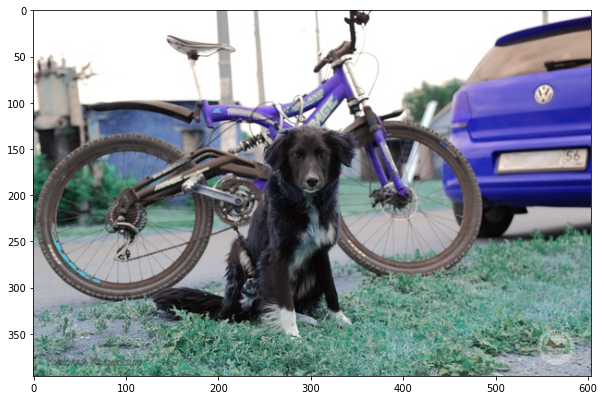

In [19]:
import matplotlib.pyplot as plt
import cv2 as cv
img = cv.imread('predictions.jpg')
plt.figure(figsize=(10,15))
plt.imshow(img)

#### Задание: "Найдите собаку". В директории /darknet/data есть файл с собакой

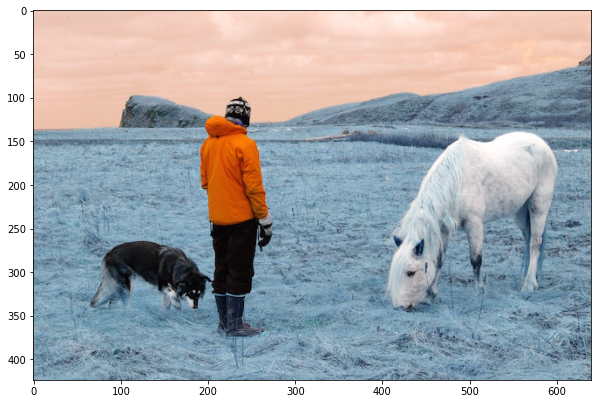

In [35]:
## !cd darknet && ./darknet detect cfg/yolov3-tiny.cfg cfg/yolov3-tiny.weights data/dog.jpg 
import matplotlib.pyplot as plt
import cv2 as cv
img = cv.imread('/content/darknet/data/person.jpg')
plt.figure(figsize=(10,15))
plt.imshow(img)

### Дообучение

Извлекаем нужный слой для переобучения

In [24]:
!cd darknet && ./darknet partial ./cfg/yolov3-tiny.cfg ./cfg/yolov3-tiny.weights yolov3-tiny.conv.15 15

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 GPU isn't used 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 256 0.399 BF
   9 max                2x 2/ 2     26 x  26 x 

Перед тем, как начать дообучать сеть, вернемся наверх, докачаем нужное количество фотографий, и обновим аннотации. 

Обновляем конфигурационный файл для нужного количества классов


In [25]:
!sed -i 's/subdivisions=2/subdivisions=8/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!sed -i 's/max_batches = 500200/max_batches = 6000/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!sed -i 's/steps=400000,450000/steps=4800,5400/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!sed -i 's/classes=80/classes=4/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!sed -i 's/filters=255/filters=27/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!cat ./darknet/cfg/yolov3-tiny_obj.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=8
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 6000
policy=steps
steps=4800,5400
scales=.1,.1

[convolutional]
batch_normalize=1
filters=16
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=1

[convolutional]
batch_normalize=1
filters=1024
s

#### Запускаем дообучение сети

In [26]:
### TRAIN TINY YOLOv3
!./darknet/darknet detector train ./OID/obj.data ./darknet/cfg/yolov3-tiny_obj.cfg ./darknet/yolov3-tiny.conv.15 -dont_show

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
yolov3-tiny_obj
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 8, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 

## Финальное задание. Техническое задание: 




Необходимый перечень классов, которые должна определять (детектировать) программа:

-  Клубника – плод красного оттенка, без листьев

-  Помидор – плод красного оттенка, без листьев, возможно с плодоножкой
 
- Огурец – плод зеленого оттенка, без листьев, возможно с плодоножкой

-  Рассада или сорняк – небольшой куст (габаритный размер не более 10х10х10 см.) зеленого оттенка.

Для выполнения задания рекомендуется:

- Расширить тренировочную выборку до не менее 1000 экземпляров

- Повторить шаги с аннотацией и сборкой описаний

** Для улучшения качества модели, рекомендуется провести аугментацию изображений и боксов класса с недостающим количеством изображений.** Обратите внимание на количество эпох

In [38]:
#@title
!python ./OIDv4_ToolKit/main.py downloader --classes Tomato Cucumber Strawberry Houseplant --type_csv train --limit 1000 --multiclasses 1 -y

!python ./OIDv4_ToolKit/main.py downloader --classes Tomato Cucumber Strawberry Houseplant --type_csv validation --limit 250 --multiclasses 1 -y

import pandas as pd
import os

f=pd.read_csv("./OID/csv_folder/train-annotations-bbox.csv")

#For multiple classes use the below, adding as many new LabelNames as needed
#this one is tomato[0] cucumber[1] strawberry[2] plant[3] in that order
numClasses = ['/m/07j87','/m/015x4r','/m/07fbm7','/m/03fp41']
u = f.loc[f['LabelName'].isin(numClasses)]
keep_col = ['LabelName','ImageID','XMin','XMax','YMin','YMax']

new_f = u[keep_col]

new_f['ClassNumber'] = new_f['LabelName']

# adding a new column for Classnumber and setting the values based on LabelName
# so, for this, it's tomato[0] cucumber[1] strawberry[2] plant[3] in that order
new_f.loc[new_f['LabelName'] == '/m/07j87', 'ClassNumber'] = 0
new_f.loc[new_f['LabelName'] == '/m/015x4r', 'ClassNumber'] = 1
new_f.loc[new_f['LabelName'] == '/m/07fbm7', 'ClassNumber'] = 2
new_f.loc[new_f['LabelName'] == '/m/03fp41', 'ClassNumber'] = 3


new_f['width'] = new_f['XMax'] - new_f['XMin']
new_f['height'] = new_f['YMax'] - new_f['YMin']
new_f['x'] = (new_f['XMax'] + new_f['XMin'])/2
new_f['y'] = (new_f['YMax'] + new_f['YMin'])/2
keep_col = ['ClassNumber','ImageID','x','y','width','height']
new_f_2 = new_f[keep_col]

print (new_f_2)

for root, dirs, files in os.walk("./OID/Dataset/train/Tomato_Cucumber_Strawberry_Houseplant/"):  
	for filename in files:

		if filename.endswith(".jpg"):
			fn = filename[:-4]
			nf = new_f_2.loc[new_f_2['ImageID'] == fn]
			keep_col = ['ClassNumber','x','y','width','height']
			new_nf = nf[keep_col]
			print(new_nf)
			imgpath = "./OID/Dataset/train/Tomato_Cucumber_Strawberry_Houseplant/" + fn + ".txt"
			print(imgpath)
			new_nf.to_csv(imgpath, index=False, header=False, sep=' ')
			
import glob
train_list = glob.glob("./OID/Dataset/train/Tomato_Cucumber_Strawberry_Houseplant/*.jpg")

with open('./OID/train.txt', 'w') as f:
    for item in train_list:
        f.write("%s\n" % item)
        
f=pd.read_csv("./OID/csv_folder/validation-annotations-bbox.csv")

#For multiple classes use the below, adding as many new LabelNames as needed
#this one is tomato[0] cucumber[1] strawberry[2] plant[3] in that order
numClasses = ['/m/07j87','/m/015x4r','/m/07fbm7','/m/03fp41']
u = f.loc[f['LabelName'].isin(numClasses)]
keep_col = ['LabelName','ImageID','XMin','XMax','YMin','YMax']

new_f = u[keep_col]

new_f['ClassNumber'] = new_f['LabelName']

# adding a new column for Classnumber and setting the values based on LabelName
# so, for this, it's tomato[0] cucumber[1] strawberry[2] plant[3] in that order
new_f.loc[new_f['LabelName'] == '/m/07j87', 'ClassNumber'] = 0
new_f.loc[new_f['LabelName'] == '/m/015x4r', 'ClassNumber'] = 1
new_f.loc[new_f['LabelName'] == '/m/07fbm7', 'ClassNumber'] = 2
new_f.loc[new_f['LabelName'] == '/m/03fp41', 'ClassNumber'] = 3


new_f['width'] = new_f['XMax'] - new_f['XMin']
new_f['height'] = new_f['YMax'] - new_f['YMin']
new_f['x'] = (new_f['XMax'] + new_f['XMin'])/2
new_f['y'] = (new_f['YMax'] + new_f['YMin'])/2
keep_col = ['ClassNumber','ImageID','x','y','width','height']
new_f_2 = new_f[keep_col]

print (new_f_2)

for root, dirs, files in os.walk("./OID/Dataset/validation/Tomato_Cucumber_Strawberry_Houseplant/"):  
	for filename in files:

		if filename.endswith(".jpg"):
			fn = filename[:-4]
			nf = new_f_2.loc[new_f_2['ImageID'] == fn]
			keep_col = ['ClassNumber','x','y','width','height']
			new_nf = nf[keep_col]
			print(new_nf)
			imgpath = "./OID/Dataset/validation/Tomato_Cucumber_Strawberry_Houseplant/" + fn + ".txt"
			print(imgpath)
			new_nf.to_csv(imgpath, index=False, header=False, sep=' ')

train_list = glob.glob("./OID/Dataset/validation/Tomato_Cucumber_Strawberry_Houseplant/*.jpg")

with open('./OID/valid.txt', 'w') as f:
    for item in train_list:
        f.write("%s\n" % item)

%%writefile ./OID/obj.names
tomato
cucumber
strawberry
plant

!cat ./OID/obj.names

%%writefile ./OID/obj.data
classes = 4
train = './OID/train.txt'
valid = './OID/valid.txt'
names = './OID/obj.names'
backup = './OID'
!cat ./OID/obj.data

!cd darknet && ./darknet partial ./cfg/yolov3-tiny.cfg ./cfg/yolov3-tiny.weights yolov3-tiny.conv.15 15
!sed -i 's/subdivisions=2/subdivisions=8/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!sed -i 's/max_batches = 500200/max_batches = 6000/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!sed -i 's/steps=400000,450000/steps=4800,5400/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!sed -i 's/classes=80/classes=4/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!sed -i 's/filters=255/filters=27/g' ./darknet/cfg/yolov3-tiny_obj.cfg
!cat ./darknet/cfg/yolov3-tiny_obj.cfg
!./darknet/darknet detector train ./OID/obj.data ./darknet/cfg/yolov3-tiny_obj.cfg ./darknet/yolov3-tiny.conv.15 -dont_show



SyntaxError: ignored

Решение можно протестировать на следующих изображениях:
1. ![Огурец](http://www.arsvest.ru/photo/img/2017/av1251/NNN/DSC_8012-.jpg)
2. ![Клубника](https://vkusvill.ru/upload/resize/58998/58998_1120x550x70_c.jpg)
3. ![Помидор](https://rastenievod.com/wp-content/uploads/2018/08/1-1-700x685.jpg)
4. ![Сорняк](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR5DU0xM27MkES5qPP9LU3PSkFlUqF5AIeD-Zl_j7nG_v120_aj&s)
5. ![HARD TEST](https://s1.1zoom.me/big0/671/Vegetables_Fruit_Cucumbers_Tomatoes_Mushrooms_560824_682x1024.jpg)

### Проверяем результат!
- Скачайте изображение с помощью утилиты wget по ссылкам выше
- Попробуйте предсказать результат, указав последние сохраненные веса
- Наслаждайтесь результатом

In [34]:
#@title
!wget http://www.arsvest.ru/photo/img/2017/av1251/NNN/DSC_8012-.jpg
!cd darknet && ./darknet detect cfg/yolov3-tiny.cfg yolov3-tiny_last.weights DSC_8012-.jpg

--2020-12-04 16:59:20--  http://www.arsvest.ru/photo/img/2017/av1251/NNN/DSC_8012-.jpg
Resolving www.arsvest.ru (www.arsvest.ru)... 5.34.183.147
Connecting to www.arsvest.ru (www.arsvest.ru)|5.34.183.147|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.arsvest.ru/photo/img/2017/av1251/NNN/DSC_8012-.jpg [following]
--2020-12-04 16:59:21--  https://www.arsvest.ru/photo/img/2017/av1251/NNN/DSC_8012-.jpg
Connecting to www.arsvest.ru (www.arsvest.ru)|5.34.183.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37660 (37K) [image/jpeg]
Saving to: ‘DSC_8012-.jpg’

DSC_8012-.jpg       100%[===================>]  36.78K  --.-KB/s    in 0.001s  

2020-12-04 16:59:21 (31.1 MB/s) - ‘DSC_8012-.jpg’ saved [37660/37660]

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train 